<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/K_Nearest_Neighbours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AMAZON FINE FOOD REVIEWS : K NEAREST NEIGHBORS 

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


**DATA SET SPLITS ** 

1. AVG_WORD2VEC : 70K TRAIN,  30K TEST
2. TFIDF_WORD2VEC : 70K TRAIN ,  30K TEST
3. BOW : 60K TRAIN,  20K CV,  20K TEST
4. TFIDF : 60K TRAIN, 20K CV,  20K TEST

## IMPORTING THE LIBRARIES 

In [0]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

** Mounting from google drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## FEATURIZATION 1 : TFIDF = WORD2VEC

In [0]:
tfw2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Train_TFW2V.sav','rb'))

In [0]:
tfw2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/Test_TFW2V.sav','rb'))

____

Creating the Train and Test set respectively for training KNN and Crossvalidation

____


In [0]:
X_train = tfw2v_train.iloc[:,0:50]
y_train = tfw2v_train['Score']
X_test = tfw2v_test.iloc[:,0:50]
y_test = tfw2v_test['Score']

** STANDARD SCALING THE DATA **

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

** 10 - FOLD CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR TFIDF WORD2VEC **

In [66]:
cv = dict()

for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree',n_jobs = -1)
  results = cross_val_score(knn,X_train,y_train,cv=10,n_jobs = -1,scoring = 'accuracy')
  results = results * 100
  cv[i] = np.mean(results)
  print("For K = " + str(i) + " Accuracy = " + str(np.mean(results)))

For K = 1 Accuracy = 85.05713314311933
For K = 3 Accuracy = 88.1199845952475
For K = 5 Accuracy = 89.06142439970837
For K = 7 Accuracy = 89.34142827932945
For K = 9 Accuracy = 89.45142766810494
For K = 11 Accuracy = 89.56285481215738


Text(0,0.5,' Accuracy ')

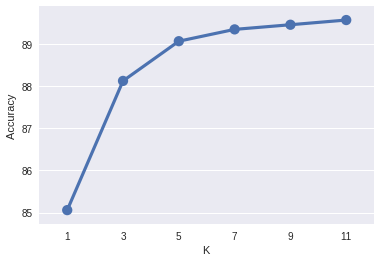

In [67]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv.values()))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

----------

The maximum accuracy is given by ** K = 11 **

1. Training the whole train on K = 11
2. Predicting for X_test 
3. Reporting the accuracy 
------


In [0]:
knn = KNeighborsClassifier(n_neighbors = 11,algorithm='kd_tree',n_jobs = -1)

In [69]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [80]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 87.98333333333333


In [81]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.69      0.22      0.33      4101
          1       0.89      0.98      0.93     25899

avg / total       0.86      0.88      0.85     30000




------------

## FEATURIZATION 2 : AVERAGE WORD2VEC
_____


In [0]:
w2v_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_train.sav','rb'))
w2v_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/avg_word2vec_test.sav','rb'))

In [0]:
X_train = w2v_train.iloc[:,0:50]
y_train = w2v_train['Score']
X_test = w2v_test.iloc[:,0:50]
y_test = w2v_test['Score']

** STANDARAD SCALING THE DATA**

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

** 10 - FOLD CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR BAG OF WORDS**

In [82]:
cv = dict()

for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors = i,algorithm='kd_tree',n_jobs = -1)
  results = cross_val_score(knn,X_train,y_train,cv=10,n_jobs = -1,scoring = 'accuracy')
  results = results * 100
  cv[i] = np.mean(results)
  print("For K = " + str(i) + " Accuracy = " + str(np.mean(results)))

For K = 1 Accuracy = 86.41139396994099
For K = 3 Accuracy = 88.95142378760923
For K = 5 Accuracy = 89.584277670408
For K = 7 Accuracy = 89.81999154900856
For K = 9 Accuracy = 89.95285522346936
For K = 11 Accuracy = 89.99999277524766


Text(0,0.5,' Accuracy ')

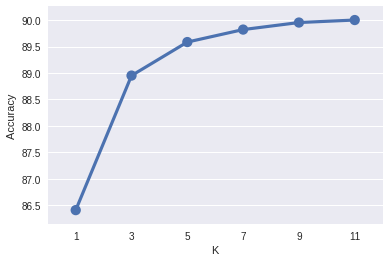

In [88]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv.values()))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

In [0]:
knn = KNeighborsClassifier(n_neighbors = 11,algorithm='kd_tree',n_jobs = -1)

In [84]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')

In [0]:
pred = knn.predict(X_test)

In [86]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 88.52333333333333


In [87]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.73      0.26      0.38      4101
          1       0.89      0.98      0.94     25899

avg / total       0.87      0.89      0.86     30000



------------

## FEATURIZATION 3 : BOW
_____

In [0]:
bow_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_bow.sav','rb'))
bow_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_bow.sav','rb'))
bow_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_bow.sav','rb'))
y_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_train.sav','rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_test.sav','rb'))
y_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/y_cv.sav','rb'))

In [0]:
sc= StandardScaler(with_mean = False)
bow_train = sc.fit_transform(bow_train)
bow_test = sc.transform(bow_test)
bow_cv = sc.transform(bow_cv)

**Function to predict : KNN : Batch by Batch, Batch size - 1000 ** 

In [0]:
def Predict(X): #passing the testing file 
  cv_pred = []
  start = 0
  next = 1000
  for i in range(0,int(np.round(X.shape[0]/1000))): #processing 1000 :  chunk by chunk
    pred = knn.predict(X[start:next])
    cv_pred = cv_pred + list(pred)
    if i == 18:
      start = 19000
      next = 20000
    else:
      start = next +1
      next = next + 1001
      
  return pd.Series(np.array(cv_pred))

** SIMPLE CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR BAG OF WORDS**

In [40]:
cv_accuracy = []
for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  knn.fit(bow_train,y_train)
  pred = Predict(bow_cv)
  print("For K = " + str(i) + " accuracy = ",str((accuracy_score(pred,y_cv))*100))
  cv_accuracy.append((accuracy_score(pred,y_cv))*100)

For K = 1 accuracy =  79.50500000000001
For K = 3 accuracy =  83.91
For K = 5 accuracy =  85.00999999999999
For K = 7 accuracy =  85.515
For K = 9 accuracy =  85.84
For K = 11 accuracy =  86.015


Text(0,0.5,' Accuracy ')

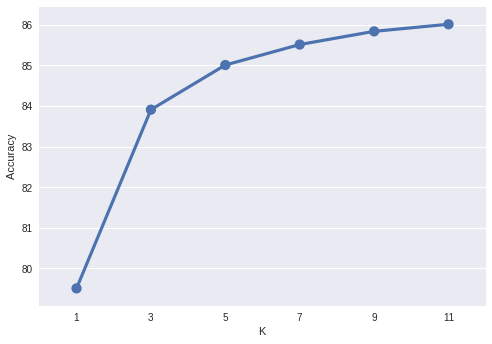

In [46]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv_accuracy))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

** K-NN : K = 11 for Bag of Words **

In [0]:
knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
knn.fit(bow_train,y_train)
pred = Predict(bow_test)

In [49]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 86.42


In [51]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.28      0.01      0.02      2674
          1       0.87      1.00      0.93     17326

avg / total       0.79      0.86      0.81     20000



------------

## FEATURIZATION 4 : TF_IDF
_____

In [0]:
tf_idf_train = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/train_tfidf.sav','rb'))
tf_idf_test = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/test_tfidf.sav','rb'))
tf_idf_cv = pickle.load(open('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/cv_tfidf.sav','rb'))

In [0]:
sc = StandardScaler(with_mean = False)
tf_idf_train = sc.fit_transform(tf_idf_train)
tf_idf_test = sc.transform(tf_idf_test)
tf_idf_cv = sc.transform(tf_idf_cv)

** SIMPLE CROSS VALIDATION : FINIDING OPTIMAL K : NEAREST NEIGHBOURS FOR TF_IDF**

In [58]:
cv = {}
for i in range(1,12,2):
  knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
  knn.fit(tf_idf_train,y_train)
  pred = Predict(tf_idf_cv)
  print("For K = " + str(i) + " accuracy = ",str((accuracy_score(pred,y_cv))*100))
  cv[i] = (accuracy_score(pred,y_cv))*100

For K = 1 accuracy =  80.58
For K = 3 accuracy =  84.57000000000001
For K = 5 accuracy =  85.53
For K = 7 accuracy =  85.955
For K = 9 accuracy =  86.15
For K = 11 accuracy =  86.225


Text(0,0.5,' Accuracy ')

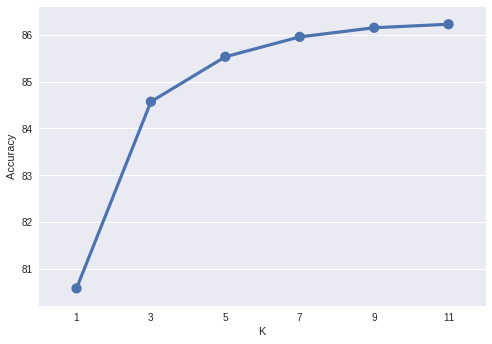

In [59]:
sns.pointplot(x = list(range(1,12,2)),y= list(cv.values()))
plt.xlabel(" K ")
plt.ylabel(" Accuracy ")

** K-NN : K = 11 for TF_IDF **

In [0]:
knn = KNeighborsClassifier(n_neighbors=11,algorithm='brute')
knn.fit(tf_idf_train,y_train)
pred = Predict(tf_idf_test)

In [11]:
print("TEST ACCURACY : "+str(accuracy_score(y_test,pred) * 100))

TEST ACCURACY : 86.58


In [12]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.22      0.00      0.00      2674
          1       0.87      1.00      0.93     17326

avg / total       0.78      0.87      0.80     20000



** OBSERVATIONS ** 

1. The recall or TPR for Negative points is very less for TF_IDF and BOW representations. In other cases TPR is fairly low ranging around 26%

2.  The precision is also low ranging from : (22%  for TF_IDF and BOW representations). For TF_IDF_Word2Vec and Average Word2Vec the precision is fairly good. 





